In [1]:
import os


def find_in_path(filename):
    for path in os.environ["PATH"].split(os.pathsep):
        full_path = os.path.join(path, filename)
        if os.path.isfile(full_path):
            return full_path
    return None

print("winutils.exe:", find_in_path("winutils.exe"))
print("hadoop.dll:", find_in_path("hadoop.dll"))

winutils.exe: C:\Users\Rodrigo\.spark\hadoop\bin\winutils.exe
hadoop.dll: C:\Users\Rodrigo\.spark\hadoop\bin\hadoop.dll


In [2]:
import os

import boto3
import requests
from botocore.exceptions import ClientError
from dotenv import load_dotenv

load_dotenv()
# Configurações do MinIO
MINIO_ENDPOINT = os.getenv("MINIO_ENDPOINT")
ACCESS_KEY = os.getenv("MINIO_USER")
SECRET_KEY = os.getenv("MINIO_PASSWORD")
print(os.getenv("AIRFLOW_PROJ_DIR"))
BUCKET_NAME = "lakehouse"

# Conectar ao MinIO (S3-compatible)
s3 = boto3.client(
    "s3",
    endpoint_url=MINIO_ENDPOINT,
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY,
)

# Checar e criar bucket
try:
    s3.head_bucket(Bucket=BUCKET_NAME)
    print(f"✅ Bucket '{BUCKET_NAME}' já existe.")
except ClientError as e:
    error_code = int(e.response["Error"]["Code"])
    if error_code == requests.codes.not_found:
        print(f"🔧 Criando bucket '{BUCKET_NAME}'...")
        s3.create_bucket(Bucket=BUCKET_NAME)
        print("✅ Bucket criado com sucesso.")
    else:
        raise


./airflow
✅ Bucket 'lakehouse' já existe.


In [3]:

import sys

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
from open_finance_lakehouse.utils.spark_session import get_spark_session


# os.environ["OPENLINEAGE_URL"] = "http://localhost:5000"  # Or your OpenLineage backend
# os.environ["OPENLINEAGE_NAMESPACE"] = "open-finance-lakehouse"

# spark_conf = {
#     "spark.extraListeners": "io.openlineage.spark.agent.OpenLineageSparkListener",
#     "spark.openlineage.transport.type": "http",
#     "spark.openlineage.transport.url": os.environ["OPENLINEAGE_URL"],
#     "spark.openlineage.namespace": os.environ["OPENLINEAGE_NAMESPACE"],
#     # Optional: authentication, job name, etc.
# }

get_spark_session.cache_clear()
spark = get_spark_session()

In [4]:
# 2. Ingestão BACEN API
import io
from datetime import datetime, timedelta

import pandas as pd
import requests

from open_finance_lakehouse.utils.spark_session import get_spark_session


def fetch_all_bacen_series(series_id, end_date=None):

    """
    Fetch all data from BACEN API for a given series_id, handling the 10-year window limit.
    Logs progress for each window.
    """
    if end_date is None:
        end_date = datetime.today()
    all_data = []
    step = 10  # years
    min_year = 1900  # BACEN data doesn't go before this
    finished = False
    window_count = 0
    while not finished:
        start_date = end_date.replace(year=max(min_year, end_date.year - step + 1))
        print(f"🔎 Fetching BACEN {series_id}: {start_date.strftime('%d/%m/%Y')} to {end_date.strftime('%d/%m/%Y')} (step={step})")
        url = (
            f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.{series_id}/dados"
            f"?formato=json&dataInicial={start_date.strftime('%d/%m/%Y')}&dataFinal={end_date.strftime('%d/%m/%Y')}"
        )
        try:
            response = requests.get(url)
            response.raise_for_status()
            df = pd.read_json(io.StringIO(response.text))
            if df.empty:
                print("⚠️  No data returned for window. Reducing step.")
                if step == 1:
                    finished = True
                else:
                    step = max(1, step - 1)
                continue
            print(f"✅ Retrieved {len(df)} rows.")
            all_data.append(df)
            window_count += 1
            # Move window back
            end_date = start_date - timedelta(days=1)
        except Exception as e:
            print(f"❌ Error: {e}. Reducing step.")
            if step == 1:
                finished = True
            else:
                step = max(1, step - 1)
    print(f"🎉 Finished fetching BACEN series {series_id}. Total windows: {window_count}")
    if all_data:
        result = pd.concat(all_data, ignore_index=True)
        result.columns = ["data", "valor"]
        result["data"] = pd.to_datetime(result["data"], format="%d/%m/%Y")
        result["valor"] = pd.to_numeric(result["valor"], errors="coerce")
        result = result.sort_values("data").reset_index(drop=True)
        print(f"📦 Total rows fetched: {len(result)}")
        return result
    else:
        print("⚠️  No data fetched from BACEN API.")
        return pd.DataFrame(columns=["data", "valor"])

# Example usage:
bacen_series_id = 11  # SELIC
df_bacen = fetch_all_bacen_series(bacen_series_id)
print(len(df_bacen), df_bacen.shape, df_bacen.dtypes, df_bacen.head())

🔎 Fetching BACEN 11: 16/07/2016 to 16/07/2025 (step=10)
✅ Retrieved 2257 rows.
🔎 Fetching BACEN 11: 15/07/2007 to 15/07/2016 (step=10)
❌ Error: 502 Server Error: Bad Gateway for url: https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial=15/07/2007&dataFinal=15/07/2016. Reducing step.
🔎 Fetching BACEN 11: 15/07/2008 to 15/07/2016 (step=9)
✅ Retrieved 2015 rows.
🔎 Fetching BACEN 11: 14/07/2000 to 14/07/2008 (step=9)
✅ Retrieved 2007 rows.
🔎 Fetching BACEN 11: 13/07/1992 to 13/07/2000 (step=9)
✅ Retrieved 2003 rows.
🔎 Fetching BACEN 11: 12/07/1984 to 12/07/1992 (step=9)
✅ Retrieved 1523 rows.
🔎 Fetching BACEN 11: 11/07/1976 to 11/07/1984 (step=9)
❌ Error: 404 Client Error: Not Found for url: https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial=11/07/1976&dataFinal=11/07/1984. Reducing step.
🔎 Fetching BACEN 11: 11/07/1977 to 11/07/1984 (step=8)
❌ Error: 404 Client Error: Not Found for url: https://api.bcb.gov.br/dados/serie/bcdata.sgs.1

In [ ]:
import os
import re
import tempfile
import zipfile
from collections import Counter
from datetime import datetime  # noqa
from difflib import get_close_matches
from functools import reduce
from pathlib import Path
from urllib.parse import urljoin

import requests
from pyspark.sql import DataFrame
from pyspark.sql import functions as F


def fetch_links(link):
    """
    Fetch all .zip links from the CVM historical page.
    Returns a list of full URLs to zip files.
    """
    try:
        resp = requests.get(link)
        resp.raise_for_status()
        # Accepts inf_diario_fi_YYYY.zip or inf_diario_fi_YYYYMM.zip
        zip_files = re.findall(r'href="(inf_diario_fi_\d{4,6}\.zip)"', resp.text)
        found = [urljoin(link, zip_file) for zip_file in zip_files]
        print(f"🔎 Found {len(found)} zip files at {link}.")
        return found
    except Exception as e:
        print(f"⚠️  Could not list or download from {link}: {e}")
        return []

def read_and_save_all_dfs(links, spark, null_log_path, raw_prefix="s3a://lakehouse/raw/cvm", overwrite=False):
    """
    For each provided .zip link, downloads and extracts the CSV, then saves as Delta.
    Returns a list of date strings.
    Checks if the dataset already exists on MinIO before downloading, unless overwrite=True.
    """
    dfs = []
    log_file = open(null_log_path, "a", encoding="utf-8")

    # MinIO/S3 client
    import boto3
    from botocore.exceptions import ClientError

    MINIO_ENDPOINT = os.getenv("MINIO_ENDPOINT", "http://localhost:9000")
    ACCESS_KEY = os.getenv("MINIO_USER")
    SECRET_KEY = os.getenv("MINIO_PASSWORD")
    s3 = boto3.client(
        "s3",
        endpoint_url=MINIO_ENDPOINT,
        aws_access_key_id=ACCESS_KEY,
        aws_secret_access_key=SECRET_KEY,
    )
    BUCKET_NAME = "lakehouse"

    for link in links:
        if not link.endswith('.zip'):
            print(f"⚠️  Skipping non-zip link: {link}")
            continue
        try:
            # Extract date_str for this file
            date_str = link.split(".")[-2].split("_")[-1]
            s3_prefix = f"raw/cvm/raw_{date_str}/"
            # Check if already exists in MinIO
            exists = False
            try:
                resp = s3.list_objects_v2(Bucket=BUCKET_NAME, Prefix=s3_prefix)
                if "Contents" in resp and any(
                    obj["Key"].endswith(".parquet") or obj["Key"].endswith(".delta") for obj in resp["Contents"]
                ):
                    exists = True
            except ClientError as e:
                print(f"⚠️  Could not check MinIO for {s3_prefix}: {e}")

            if exists and not overwrite:
                print(f"✅ Dataset for {date_str} already exists in MinIO, skipping download.")
                dfs.append(date_str)
                continue
            elif exists and overwrite:
                print(f"♻️  Overwriting dataset for {date_str} in MinIO.")

            response = requests.get(link)
            print(f"🔍 Downloading {link}: {response.status_code}")
            if response.status_code != requests.codes.ok:
                print(f"⚠️  No valid file for {link}.")
                continue

            # Save as temp file
            with tempfile.NamedTemporaryFile(delete=False, suffix=".zip") as tmp:
                tmp.write(response.content)
                tmp_path = tmp.name

            # Always extract CSV from ZIP
            try:
                with zipfile.ZipFile(tmp_path, 'r') as zip_ref:
                    csv_names = [n for n in zip_ref.namelist() if n.lower().endswith('.csv') or n.lower().endswith('.txt')]
                    if not csv_names:
                        print(f"⚠️  No CSV/TXT found in zip for {link}.")
                        os.unlink(tmp_path)
                        continue
                    csv_name = csv_names[0]
                    zip_ref.extract(csv_name, os.path.dirname(tmp_path))
                    file_to_read = os.path.join(os.path.dirname(tmp_path), csv_name)
            except zipfile.BadZipFile:
                print(f"⚠️  Not a valid zip file for {link}.")
                os.unlink(tmp_path)
                continue

            # Read extracted CSV with Spark
            try:
                df = spark.read.csv(
                    file_to_read,
                    header=True,
                    sep=";",
                    inferSchema=True,
                    encoding="ISO-8859-1"
                )
            except Exception as e:
                print(f"⚠️  Could not read {link} as CSV: {e}")
                os.unlink(tmp_path)
                if os.path.exists(file_to_read):
                    os.unlink(file_to_read)
                continue

            # Sanitize column names for Delta
            for col in df.columns:
                clean_col = re.sub(r'[ ,;{}()\n\t=]', '_', col)
                if clean_col != col:
                    df = df.withColumnRenamed(col, clean_col)

            row_count = df.count()
            if row_count == 0:
                print(f"⚠️  No data found for {link}.")
                os.unlink(tmp_path)
                if os.path.exists(file_to_read):
                    os.unlink(file_to_read)
                continue

            df.cache()
            cnpj_col = None
            for col in df.columns:
                if "cnpj" in col.lower():
                    cnpj_col = col
                    print(f"🔍 Found CNPJ column: {cnpj_col}")
                    break
            if cnpj_col:
                null_cnpj_rows = df.filter(F.col(cnpj_col).isNull())
                null_count = null_cnpj_rows.count()
                print(f"🔍 Found {null_count} null CNPJ rows in {link}.")
                if null_count > 0:
                    print(f"⚠️  {null_count} rows with null {cnpj_col} in {link}. Logging to {null_log_path}")
                    rows = null_cnpj_rows.toPandas().to_dict(orient="records")
                    for row in rows:
                        log_file.write(f"{link}: {row}\n")
            else:
                print("⚠️  No CNPJ column found for null check.")

            print(f"🔍 Extracted date string: {date_str}")
            # Save to bronze
            df.write.format("delta").mode("overwrite").save(f"{raw_prefix}/raw_{date_str}/")
            dfs.append(date_str)
            print(f"✅ Loaded and saved {link} with {row_count} rows")
            os.unlink(tmp_path)
            if os.path.exists(file_to_read):
                os.unlink(file_to_read)
        except Exception as e:
            print(f"⚠️  Failed to fetch or load {link}: {e}")

    log_file.close()
    return dfs

# Usage in notebook:
link_historico = "https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/HIST/"
cvm_url = "https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/"
null_log_path = Path("null_cnpj_log.txt")
links = fetch_links(link_historico) + fetch_links(cvm_url)
dfs = read_and_save_all_dfs(links, spark, null_log_path)


🔎 Found 21 zip files at https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/HIST/.
🔎 Found 55 zip files at https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/.
🔍 Downloading https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/HIST/inf_diario_fi_2000.zip: 200
🔍 Found CNPJ column: CNPJ_FUNDO
🔍 Found 0 null CNPJ rows in https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/HIST/inf_diario_fi_2000.zip.
🔍 Extracted date string: 2000


In [ ]:
from pprint import pprint


def fuzzy_normalize_df(df, target_cols, cutoff=0.65):
    CNPJ_ALIASES = ["CNPJ_FUNDO", "CNPJ_FUNDO_CLASSE", "CNPJ"]
    TP_ALIASES = ["TP_FUNDO", "TP_FUNDO_CLASSE"]
    col_map = {}
    for target in target_cols:
        aliases = []
        if target == "CNPJ_FUNDO":
            aliases = CNPJ_ALIASES
        elif target == "TP_FUNDO":
            aliases = TP_ALIASES
        match = [col for col in df.columns if col in aliases]
        if not match:
            match = get_close_matches(target, df.columns, n=1, cutoff=cutoff)
        if match:
            if match[0] != target and match[0] in target_cols:
                print(f"⚠️  Fuzzy match '{match[0]}' to '{target}' skipped (would cross-map target columns)")
                continue
            col_map[match[0]] = target
        else:
            print(f"❌ No matching column found for '{target}' in {df.columns}")
    # Rename columns that match
    for src, tgt in col_map.items():
        if src != tgt:
            df = df.withColumnRenamed(src, tgt)
            print(f"✅ Fuzzy normalized column '{src}' to '{tgt}'")
    # Add missing columns as nulls
    for col in target_cols:
        if col not in df.columns:
            print(f"⚠️  Added missing column '{col}' as nulls to {df.columns}")
            df = df.withColumn(col, F.lit(None))
    # Select only target columns in order
    df = df.select([col for col in target_cols])
    return df

def reduce_all_dfs(dfs, spark):
    """
    Reloads the raw DataFrames from the bronze layer for normalization and reduction.
    Returns the unified DataFrame.
    """
    dfs_bronze = [
        (date_str,spark.read.format("delta").load(f"s3a://lakehouse/raw/cvm/raw_{date_str}/"))
        for date_str in dfs
    ]
    original_col_types = {}
    for date_str, df in dfs_bronze:
        for name, dtype in df.dtypes:
            if name not in original_col_types:
                original_col_types[name] = set()
            original_col_types[name].add(dtype)
    # Fuzzy schema normalization
    colname_lists = [tuple(sorted(df.columns)) for  _, df in dfs_bronze]
    most_common_cols, _ = Counter(colname_lists).most_common(1)[0]
    most_common_cols = list(most_common_cols)


    dfs_normalized = [fuzzy_normalize_df(df, most_common_cols) for  _, df in dfs_bronze]
    normalized_col_types = {}
    for idx, df in enumerate(dfs_normalized):
        for name, dtype in df.dtypes:
            if name not in normalized_col_types:
                normalized_col_types[name] = set()
            normalized_col_types[name].add(dtype)

    pprint(f"Normalized column sets: {normalized_col_types}")

    cvm_spark_df = reduce(DataFrame.unionByName, reversed(dfs_normalized))
    return cvm_spark_df

if dfs:
    cvm_spark_df = reduce_all_dfs(dfs, spark)
else:
    print("⚠️ No CVM data was fetched. The DataFrame list is empty.")

⚠️  Fuzzy match 'CNPJ_FUNDO' to 'TP_FUNDO' skipped (would cross-map target columns)
⚠️  Added missing column 'TP_FUNDO' as nulls to ['CNPJ_FUNDO', 'DT_COMPTC', 'VL_TOTAL', 'VL_QUOTA', 'VL_PATRIM_LIQ', 'CAPTC_DIA', 'RESG_DIA', 'NR_COTST']
⚠️  Fuzzy match 'CNPJ_FUNDO' to 'TP_FUNDO' skipped (would cross-map target columns)
⚠️  Added missing column 'TP_FUNDO' as nulls to ['CNPJ_FUNDO', 'DT_COMPTC', 'VL_TOTAL', 'VL_QUOTA', 'VL_PATRIM_LIQ', 'CAPTC_DIA', 'RESG_DIA', 'NR_COTST']
⚠️  Fuzzy match 'CNPJ_FUNDO' to 'TP_FUNDO' skipped (would cross-map target columns)
⚠️  Added missing column 'TP_FUNDO' as nulls to ['CNPJ_FUNDO', 'DT_COMPTC', 'VL_TOTAL', 'VL_QUOTA', 'VL_PATRIM_LIQ', 'CAPTC_DIA', 'RESG_DIA', 'NR_COTST']
⚠️  Fuzzy match 'CNPJ_FUNDO' to 'TP_FUNDO' skipped (would cross-map target columns)
⚠️  Added missing column 'TP_FUNDO' as nulls to ['CNPJ_FUNDO', 'DT_COMPTC', 'VL_TOTAL', 'VL_QUOTA', 'VL_PATRIM_LIQ', 'CAPTC_DIA', 'RESG_DIA', 'NR_COTST']
⚠️  Fuzzy match 'CNPJ_FUNDO' to 'TP_FUNDO' skipp

In [ ]:
print(
    f"Rows: {cvm_spark_df.count()}",
    f"Columns: {len(cvm_spark_df.columns)}",
    f"Schema: {cvm_spark_df.dtypes}",
    sep="\n"
)
cvm_spark_df.show(5, truncate=False)

Rows: 31304705
Columns: 9
Schema: [('CAPTC_DIA', 'double'), ('CNPJ_FUNDO', 'string'), ('DT_COMPTC', 'date'), ('NR_COTST', 'string'), ('RESG_DIA', 'double'), ('TP_FUNDO', 'string'), ('VL_PATRIM_LIQ', 'double'), ('VL_QUOTA', 'double'), ('VL_TOTAL', 'string')]
+----------+------------------+----------+--------+-------------+-------------+--------------+------------+---------------+
|CAPTC_DIA |CNPJ_FUNDO        |DT_COMPTC |NR_COTST|RESG_DIA     |TP_FUNDO     |VL_PATRIM_LIQ |VL_QUOTA    |VL_TOTAL       |
+----------+------------------+----------+--------+-------------+-------------+--------------+------------+---------------+
|0.0       |00.826.901/0001-37|2025-05-02|96      |0.0          |CLASSES - FIF|1.079265371E7 |121.09143   |1.079740192E7  |
|0.0       |00.832.453/0001-84|2025-05-02|17      |0.0          |CLASSES - FIF|2571258.29    |40.2206282  |2576537.91     |
|0.0       |02.980.941/0001-64|2025-05-02|3       |0.0          |CLASSES - FIF|4.14821473E7  |176.87028205|4.149234273E7  

In [ ]:
cvm_spark_df.filter(F.col("CNPJ_FUNDO").isNull()).show(5, truncate=False)

+---------+----------+---------+--------+--------+--------+-------------+--------+--------+
|CAPTC_DIA|CNPJ_FUNDO|DT_COMPTC|NR_COTST|RESG_DIA|TP_FUNDO|VL_PATRIM_LIQ|VL_QUOTA|VL_TOTAL|
+---------+----------+---------+--------+--------+--------+-------------+--------+--------+
+---------+----------+---------+--------+--------+--------+-------------+--------+--------+



In [ ]:
# 3. Salvar como Delta (Bronze) no MinIO
df_bacen_spark = spark.createDataFrame(df_bacen)

In [ ]:
# Ensure NR_COTST is always integer before saving
from pyspark.sql.types import DoubleType, IntegerType

if "NR_COTST" in cvm_spark_df.columns:
    cvm_spark_df = cvm_spark_df.withColumn("NR_COTST", F.col("NR_COTST").cast(IntegerType()))
if "VL_TOTAL" in cvm_spark_df.columns:
    cvm_spark_df = cvm_spark_df.withColumn("VL_TOTAL", F.col("VL_TOTAL").cast(DoubleType()))



In [ ]:
df_bacen_spark.write.format("delta").mode("overwrite").save("s3a://lakehouse/bronze/bacen_selic/")
cvm_spark_df.write.format("delta").mode("overwrite").save("s3a://lakehouse/bronze/cvm_if_di/")

In [ ]:
# 4. Transformações da camada Silver
from pyspark.sql import functions as F

silver_bacen = (
    df_bacen_spark
    .withColumn("ano", F.year("data"))
    .withColumn("mes", F.month("data"))
    .withColumn("dia", F.dayofmonth("data"))
)

silver_cvm = (
    cvm_spark_df.withColumn("cap_liquida_dia", F.col("CAPTC_DIA") - F.col("RESG_DIA"))
        .withColumn("ano", F.year("DT_COMPTC"))
        .withColumn("mes", F.month("DT_COMPTC"))
        .withColumn("dia", F.dayofmonth("DT_COMPTC"))
        .filter(F.col("VL_QUOTA") > 0)
        .filter(F.col("VL_PATRIM_LIQ") > 0)
)




silver_bacen.write.format("delta").mode("overwrite").save("s3a://lakehouse/silver/bacen_selic/")
silver_cvm.write.format("delta").mode("overwrite").save("s3a://lakehouse/silver/cvm_if_di/")


In [ ]:
silver_cvm.show(20, truncate=False)

+-------------+------------------+----------+--------+-------------+-------------+---------------+------------+---------------+---------------------+----+---+---+
|CAPTC_DIA    |CNPJ_FUNDO        |DT_COMPTC |NR_COTST|RESG_DIA     |TP_FUNDO     |VL_PATRIM_LIQ  |VL_QUOTA    |VL_TOTAL       |cap_liquida_dia      |ano |mes|dia|
+-------------+------------------+----------+--------+-------------+-------------+---------------+------------+---------------+---------------------+----+---+---+
|0.0          |00.826.901/0001-37|2025-05-02|96      |0.0          |CLASSES - FIF|1.079265371E7  |121.09143   |1.079740192E7  |0.0                  |2025|5  |2  |
|0.0          |00.832.453/0001-84|2025-05-02|17      |0.0          |CLASSES - FIF|2571258.29     |40.2206282  |2576537.91     |0.0                  |2025|5  |2  |
|0.0          |02.980.941/0001-64|2025-05-02|3       |0.0          |CLASSES - FIF|4.14821473E7   |176.87028205|4.149234273E7  |0.0                  |2025|5  |2  |
|8181285.28   |04.299.

In [ ]:
# Count nulls in CNPJ_FUNDO
null_count = silver_cvm.filter(F.col("CNPJ_FUNDO").isNull()).count()
total_count = silver_cvm.count()
print(f"Nulls in CNPJ_FUNDO: {null_count} of {total_count} ({null_count/total_count:.2%})")

# Show some rows with null CNPJ_FUNDO
silver_cvm.filter(
    (F.col("CNPJ_FUNDO").isNull()) & (F.col("NR_COTST") > 1)
).show(30, truncate=False)

Nulls in CNPJ_FUNDO: 0 of 31120815 (0.00%)
+---------+----------+---------+--------+--------+--------+-------------+--------+--------+---------------+---+---+---+
|CAPTC_DIA|CNPJ_FUNDO|DT_COMPTC|NR_COTST|RESG_DIA|TP_FUNDO|VL_PATRIM_LIQ|VL_QUOTA|VL_TOTAL|cap_liquida_dia|ano|mes|dia|
+---------+----------+---------+--------+--------+--------+-------------+--------+--------+---------------+---+---+---+
+---------+----------+---------+--------+--------+--------+-------------+--------+--------+---------------+---+---+---+



In [ ]:
silver_cvm.count()

31120815

In [ ]:
import great_expectations as gx
from great_expectations.core.expectation_configuration import ExpectationConfiguration

context = gx.data_context.DataContext("gx")

# (Re-)register the asset with the current DataFrame
spark_ds = context.get_datasource("spark_datasource")
if "silver_bacen_selic" in [asset.name for asset in spark_ds.assets]:
    spark_ds.delete_asset("silver_bacen_selic")
spark_ds.add_dataframe_asset(name="silver_bacen_selic", dataframe=df_bacen_spark)

# Overwrite the expectation suite with only valid expectations (NO validation run)
suite_name = "silver_bacen_selic_suite"
if suite_name in [suite.expectation_suite_name for suite in context.list_expectation_suites()]:
    context.delete_expectation_suite(suite_name)
suite = context.add_expectation_suite(suite_name)

# Add expectations directly to the suite (no validator, no data access)
suite.expectations = [
    ExpectationConfiguration(
        expectation_type="expect_column_to_exist",
        kwargs={"column": "data"}
    ),
    ExpectationConfiguration(
        expectation_type="expect_column_to_exist",
        kwargs={"column": "valor"}
    ),
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_not_be_null",
        kwargs={"column": "data"}
    ),
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_not_be_null",
        kwargs={"column": "valor"}
    ),
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_of_type",
        kwargs={"column": "data", "type_": "TimestampType"}
    ),
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_of_type",
        kwargs={"column": "valor", "type_": "DoubleType"}
    ),
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_between",
        kwargs={"column": "valor", "min_value": 0}
    ),
    ExpectationConfiguration(
        expectation_type="expect_table_row_count_to_be_between",
        kwargs={"min_value": 1}
    ),
]

context.save_expectation_suite(suite)
print("✅ Clean expectation suite created and saved (no validation run, no validator used).")

✅ Clean expectation suite created and saved (no validation run, no validator used).


In [ ]:
import great_expectations as gx
from great_expectations.core.expectation_configuration import ExpectationConfiguration

context = gx.data_context.DataContext("gx")

# (Re-)register the asset with the current DataFrame
spark_ds = context.get_datasource("spark_datasource")
if "silver_cvm_if_di" in [asset.name for asset in spark_ds.assets]:
    spark_ds.delete_asset("silver_cvm_if_di")
spark_ds.add_dataframe_asset(name="silver_cvm_if_di", dataframe=silver_cvm)

# Overwrite the expectation suite with only valid expectations (NO validation run)
suite_name = "silver_cvm_if_di_suite"
if suite_name in [suite.expectation_suite_name for suite in context.list_expectation_suites()]:
    context.delete_expectation_suite(suite_name)
suite = context.add_expectation_suite(suite_name)

# Add expectations directly to the suite (no validator, no data access)
suite.expectations = [
    ExpectationConfiguration(
        expectation_type="expect_column_to_exist",
        kwargs={"column": "DT_COMPTC"}
    ),
    ExpectationConfiguration(
        expectation_type="expect_column_to_exist",
        kwargs={"column": "CNPJ_FUNDO"}
    ),
    ExpectationConfiguration(
        expectation_type="expect_column_to_exist",
        kwargs={"column": "VL_QUOTA"}
    ),
    ExpectationConfiguration(
        expectation_type="expect_column_to_exist",
        kwargs={"column": "VL_PATRIM_LIQ"}
    ),
    ExpectationConfiguration(
        expectation_type="expect_column_to_exist",
        kwargs={"column": "cap_liquida_dia"}
    ),
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_not_be_null",
        kwargs={"column": "DT_COMPTC"}
    ),
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_not_be_null",
        kwargs={"column": "CNPJ_FUNDO"}
    ),
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_not_be_null",
        kwargs={"column": "VL_QUOTA"}
    ),
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_not_be_null",
        kwargs={"column": "VL_PATRIM_LIQ"}
    ),
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_of_type",
        kwargs={"column": "DT_COMPTC", "type_": "DateType"}
    ),
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_of_type",
        kwargs={"column": "VL_QUOTA", "type_": "DoubleType"}
    ),
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_of_type",
        kwargs={"column": "VL_PATRIM_LIQ", "type_": "DoubleType"}
    ),
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_between",
        kwargs={"column": "VL_QUOTA", "min_value": 0}
    ),
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_between",
        kwargs={"column": "VL_PATRIM_LIQ", "min_value": 0}
    ),
    ExpectationConfiguration(
        expectation_type="expect_table_row_count_to_be_between",
        kwargs={"min_value": 1}
    ),
]

context.save_expectation_suite(suite)
print("✅ Clean expectation suite for silver_cvm created and saved (no validation run, no validator used).")

✅ Clean expectation suite for silver_cvm created and saved (no validation run, no validator used).


In [ ]:
import great_expectations as gx
from great_expectations.checkpoint import SimpleCheckpoint

context = gx.data_context.DataContext("gx")

# Ensure Spark datasource exists
if "spark_datasource" not in context.datasources:
    context.sources.add_spark(name="spark_datasource")

# (Re-)register the assets with the current DataFrames
spark_ds = context.get_datasource("spark_datasource")
asset_names = [asset.name for asset in spark_ds.assets]
if "silver_bacen_selic" in asset_names:
    spark_ds.delete_asset("silver_bacen_selic")
if "silver_cvm_if_di" in asset_names:
    spark_ds.delete_asset("silver_cvm_if_di")
spark_ds.add_dataframe_asset(name="silver_bacen_selic", dataframe=df_bacen_spark)
spark_ds.add_dataframe_asset(name="silver_cvm_if_di", dataframe=silver_cvm)

# Ensure expectation suites exist
suite_names = [suite.expectation_suite_name for suite in context.list_expectation_suites()]
if "silver_bacen_selic_suite" not in suite_names:
    context.add_expectation_suite("silver_bacen_selic_suite")
if "silver_cvm_if_di_suite" not in suite_names:
    context.add_expectation_suite("silver_cvm_if_di_suite")

# Build batch requests
batch_request_bacen = {
    "datasource_name": "spark_datasource",
    "data_asset_name": "silver_bacen_selic",
}
batch_request_cvm = {
    "datasource_name": "spark_datasource",
    "data_asset_name": "silver_cvm_if_di",
}

# Run the checkpoint for both assets
checkpoint = SimpleCheckpoint(
    name="silver_combined_checkpoint",
    data_context=context,
    validations=[
        {
            "batch_request": batch_request_bacen,
            "expectation_suite_name": "silver_bacen_selic_suite",
        },
        {
            "batch_request": batch_request_cvm,
            "expectation_suite_name": "silver_cvm_if_di_suite",
        }
    ]
)

result = checkpoint.run()
print("✅ Validation Success (bacen & cvm):", result["success"])

Calculating Metrics:   0%|          | 0/22 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/40 [00:00<?, ?it/s]

✅ Validation Success (bacen & cvm): True


In [ ]:
for run_result in result["run_results"].values():
    validation_result = run_result["validation_result"]
    for res in validation_result["results"]:
        if not res["success"]:
            print(f"❌ Failed: {res['expectation_config']['expectation_type']} on column {res['expectation_config']['kwargs'].get('column')}")
            print(f"    Details: {res['result']}")

In [ ]:
from pyspark.sql import functions as F

def run_gold_pipeline():
    # Load silver datasets
    # silver_cvm = spark.read.format("delta").load("s3a://lakehouse/silver/cvm/")
    silver_bacen = spark.read.format("delta").load("s3a://lakehouse/silver/bacen_selic/")

    # KPIs CVM Fundos
    gold_cvm = (
        silver_cvm.groupBy("CNPJ_FUNDO")
        .agg(
            F.min("DT_COMPTC").alias("data_inicio"),
            F.max("DT_COMPTC").alias("data_fim"),
            F.first("VL_QUOTA", ignorenulls=True).alias("vl_quota_inicio"),
            F.last("VL_QUOTA", ignorenulls=True).alias("vl_quota_fim"),
            F.sum("cap_liquida_dia").alias("cap_liquida_total"),
            F.first("NR_COTST", ignorenulls=True).alias("cotistas_inicio"),
            F.last("NR_COTST", ignorenulls=True).alias("cotistas_fim"),
            F.first("TP_FUNDO", ignorenulls=True).alias("TP_FUNDO")  # <-- Adicione esta linha
        )
        .withColumn(
            "rentabilidade_pct",
            ((F.col("vl_quota_fim") - F.col("vl_quota_inicio")) / F.col("vl_quota_inicio")) * 100
        )
        .withColumn(
            "anos",
            (F.datediff(F.col("data_fim"), F.col("data_inicio")) / 365.25)
        )
        .withColumn(
            "rentabilidade_anualizada_pct",
            (
                (F.col("vl_quota_fim") / F.col("vl_quota_inicio")) ** (1 / F.col("anos")) - 1
            ) * 100
        )
        .withColumn(
            "crescimento_cotistas",
            F.col("cotistas_fim") - F.col("cotistas_inicio")
        )
    )

    # KPIs BACEN indicadores
    gold_bacen = (
        silver_bacen.agg(
            F.min("data").alias("inicio"),
            F.max("data").alias("fim"),
            F.min("valor").alias("min"),
            F.max("valor").alias("max"),
            F.mean("valor").alias("media")
        )
    )

    gold_bacen.write.format("delta").mode("overwrite").save("s3a://lakehouse/gold/bacen_kpis/")
    gold_cvm.write.format("delta").mode("overwrite").option("overwriteSchema", "true").save("s3a://lakehouse/gold/cvm_kpis/")
    return gold_bacen, gold_cvm

gold_bacen, gold_cvm = run_gold_pipeline()
gold_bacen.show(20, truncate=False)
gold_cvm.orderBy("data_inicio", ascending=True).show(20, truncate=False)

+-------------------+-------------------+---+-----+------------------+
|inicio             |fim                |min|max  |media             |
+-------------------+-------------------+---+-----+------------------+
|1986-06-04 00:00:00|2025-05-02 00:00:00|0.0|3.626|0.2555546988618886|
+-------------------+-------------------+---+-----+------------------+

+------------------+-----------+----------+---------------+------------+---------------------+---------------+------------+-------------+-------------------+------------------+----------------------------+--------------------+
|CNPJ_FUNDO        |data_inicio|data_fim  |vl_quota_inicio|vl_quota_fim|cap_liquida_total    |cotistas_inicio|cotistas_fim|TP_FUNDO     |rentabilidade_pct  |anos              |rentabilidade_anualizada_pct|crescimento_cotistas|
+------------------+-----------+----------+---------------+------------+---------------------+---------------+------------+-------------+-------------------+------------------+--------------

In [ ]:
from pyspark.sql.functions import format_number

# Ordenar numericamente antes de formatar para string
t = gold_cvm.filter(F.col("rentabilidade_anualizada_pct") != 0) \
    .orderBy(F.col("rentabilidade_anualizada_pct").desc()) \
    .withColumn("rentabilidade_anualizada_pct", format_number("rentabilidade_anualizada_pct", 2)) \

t.show(20, truncate=False)

+------------------+-----------+----------+---------------+-------------------+-------------------+---------------+------------+-------------+---------------------+---------------------+-----------------------------------------+--------------------+
|CNPJ_FUNDO        |data_inicio|data_fim  |vl_quota_inicio|vl_quota_fim       |cap_liquida_total  |cotistas_inicio|cotistas_fim|TP_FUNDO     |rentabilidade_pct    |anos                 |rentabilidade_anualizada_pct             |crescimento_cotistas|
+------------------+-----------+----------+---------------+-------------------+-------------------+---------------+------------+-------------+---------------------+---------------------+-----------------------------------------+--------------------+
|06.084.833/0001-64|2005-01-03 |2005-01-31|1.0            |101.25346666       |4150079.11         |1              |32          |NULL         |10025.346666         |0.07665982203969883  |14,449,603,971,714,631,000,000,000,000.00|31                  |


In [ ]:
gold_cvm.count()

52054

In [ ]:
t.count()

51993

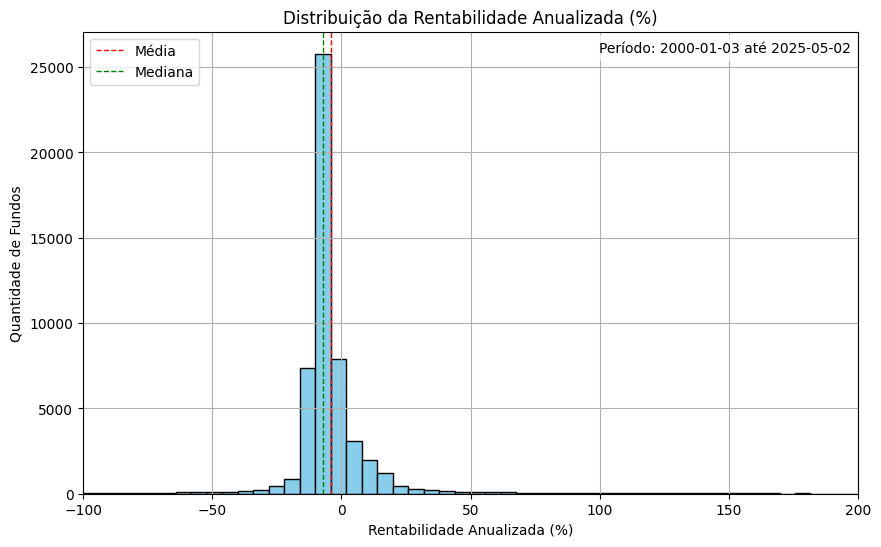

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Obter menor e maior data do gold_cvm
min_date, max_date = gold_cvm.agg(
    F.min("data_inicio"), F.max("data_fim")
).first()

# Filtrar valores válidos para o histograma
valid = gold_cvm.filter(
    (F.col("rentabilidade_anualizada_pct").isNotNull()) &
    (F.col("rentabilidade_anualizada_pct") > -100) &
    (F.col("rentabilidade_anualizada_pct") < 200)
)

rentabilidades = (
    valid.select("rentabilidade_anualizada_pct")
    .rdd.flatMap(lambda x: [x[0]])
    .filter(lambda x: x is not None and np.isfinite(x))
    .collect()
)

plt.figure(figsize=(10,6))
plt.hist(rentabilidades, bins=50, color="skyblue", edgecolor="black")
plt.title("Distribuição da Rentabilidade Anualizada (%)")
plt.xlabel("Rentabilidade Anualizada (%)")
plt.ylabel("Quantidade de Fundos")
plt.xlim(-100, 200)
plt.grid(True)

# Adicionar faixa de datas no gráfico
# Corrigir: min_date e max_date já são datetime.date, não use .date()
date_range = f"Período: {min_date} até {max_date}"
plt.text(
    0.99, 0.98, date_range,
    ha="right", va="top",
    transform=plt.gca().transAxes,
    fontsize=10,
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)
plt.axvline(np.mean(rentabilidades), color='red', linestyle='dashed', linewidth=1, label='Média')
plt.axvline(np.median(rentabilidades), color='green', linestyle='dashed', linewidth=1, label='Mediana')
plt.legend()
plt.show()

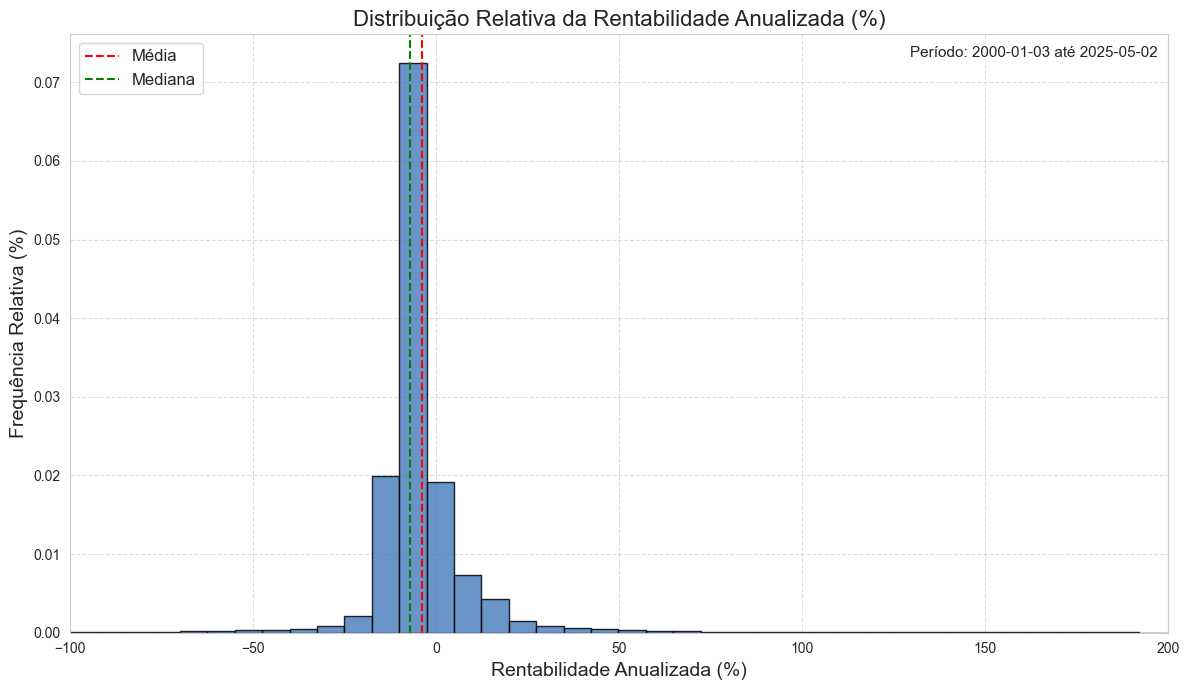

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(12,7))
counts, bins, patches = plt.hist(
    rentabilidades, bins=40, color="#4F81BD", edgecolor="black", alpha=0.85, density=True
)
plt.title("Distribuição Relativa da Rentabilidade Anualizada (%)", fontsize=16)
plt.xlabel("Rentabilidade Anualizada (%)", fontsize=14)
plt.ylabel("Frequência Relativa (%)", fontsize=14)
plt.xlim(-100, 200)
plt.grid(True, linestyle='--', alpha=0.7)

# Média e mediana
plt.axvline(np.mean(rentabilidades), color='red', linestyle='dashed', linewidth=1.5, label='Média')
plt.axvline(np.median(rentabilidades), color='green', linestyle='dashed', linewidth=1.5, label='Mediana')
plt.legend(fontsize=12)

# Faixa de datas
date_range = f"Período: {min_date} até {max_date}"
plt.text(
    0.99, 0.98, date_range,
    ha="right", va="top",
    transform=plt.gca().transAxes,
    fontsize=11,
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)

plt.tight_layout()
plt.show()

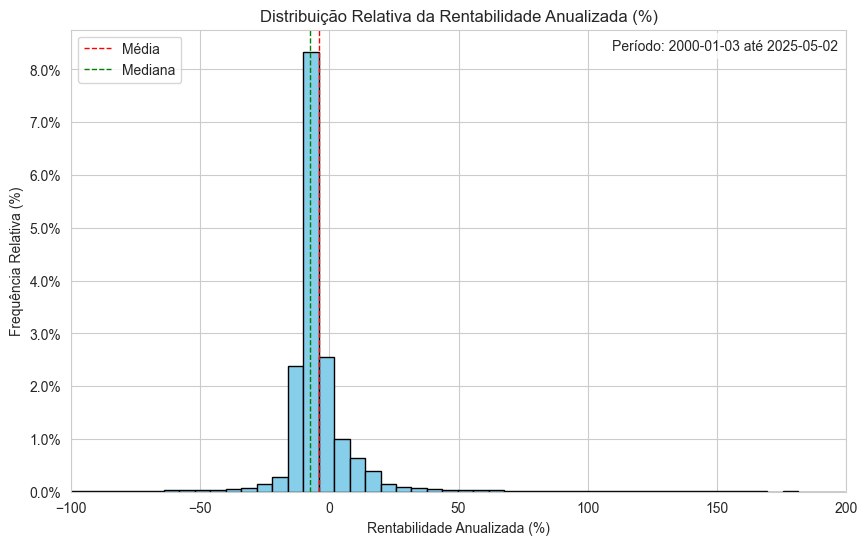

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Obter menor e maior data do gold_cvm
min_date, max_date = gold_cvm.agg(
    F.min("data_inicio"), F.max("data_fim")
).first()

# Filtrar valores válidos para o histograma
valid = gold_cvm.filter(
    (F.col("rentabilidade_anualizada_pct").isNotNull()) &
    (F.col("rentabilidade_anualizada_pct") > -100) &
    (F.col("rentabilidade_anualizada_pct") < 200)
)

rentabilidades = (
    valid.select("rentabilidade_anualizada_pct")
    .rdd.flatMap(lambda x: [x[0]])
    .filter(lambda x: x is not None and np.isfinite(x))
    .collect()
)

plt.figure(figsize=(10,6))
counts, bins, patches = plt.hist(
    rentabilidades, bins=50, color="skyblue", edgecolor="black", density=True
)
plt.title("Distribuição Relativa da Rentabilidade Anualizada (%)")
plt.xlabel("Rentabilidade Anualizada (%)")
plt.ylabel("Frequência Relativa (%)")
plt.xlim(-100, 200)
plt.grid(True)

# Converter para porcentagem no eixo Y
yticks = plt.gca().get_yticks()
plt.gca().set_yticklabels([f"{y*100:.1f}%" for y in yticks])

# Adicionar faixa de datas no gráfico
date_range = f"Período: {min_date} até {max_date}"
plt.text(
    0.99, 0.98, date_range,
    ha="right", va="top",
    transform=plt.gca().transAxes,
    fontsize=10,
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)
plt.axvline(np.mean(rentabilidades), color='red', linestyle='dashed', linewidth=1, label='Média')
plt.axvline(np.median(rentabilidades), color='green', linestyle='dashed', linewidth=1, label='Mediana')
plt.legend()
plt.show()

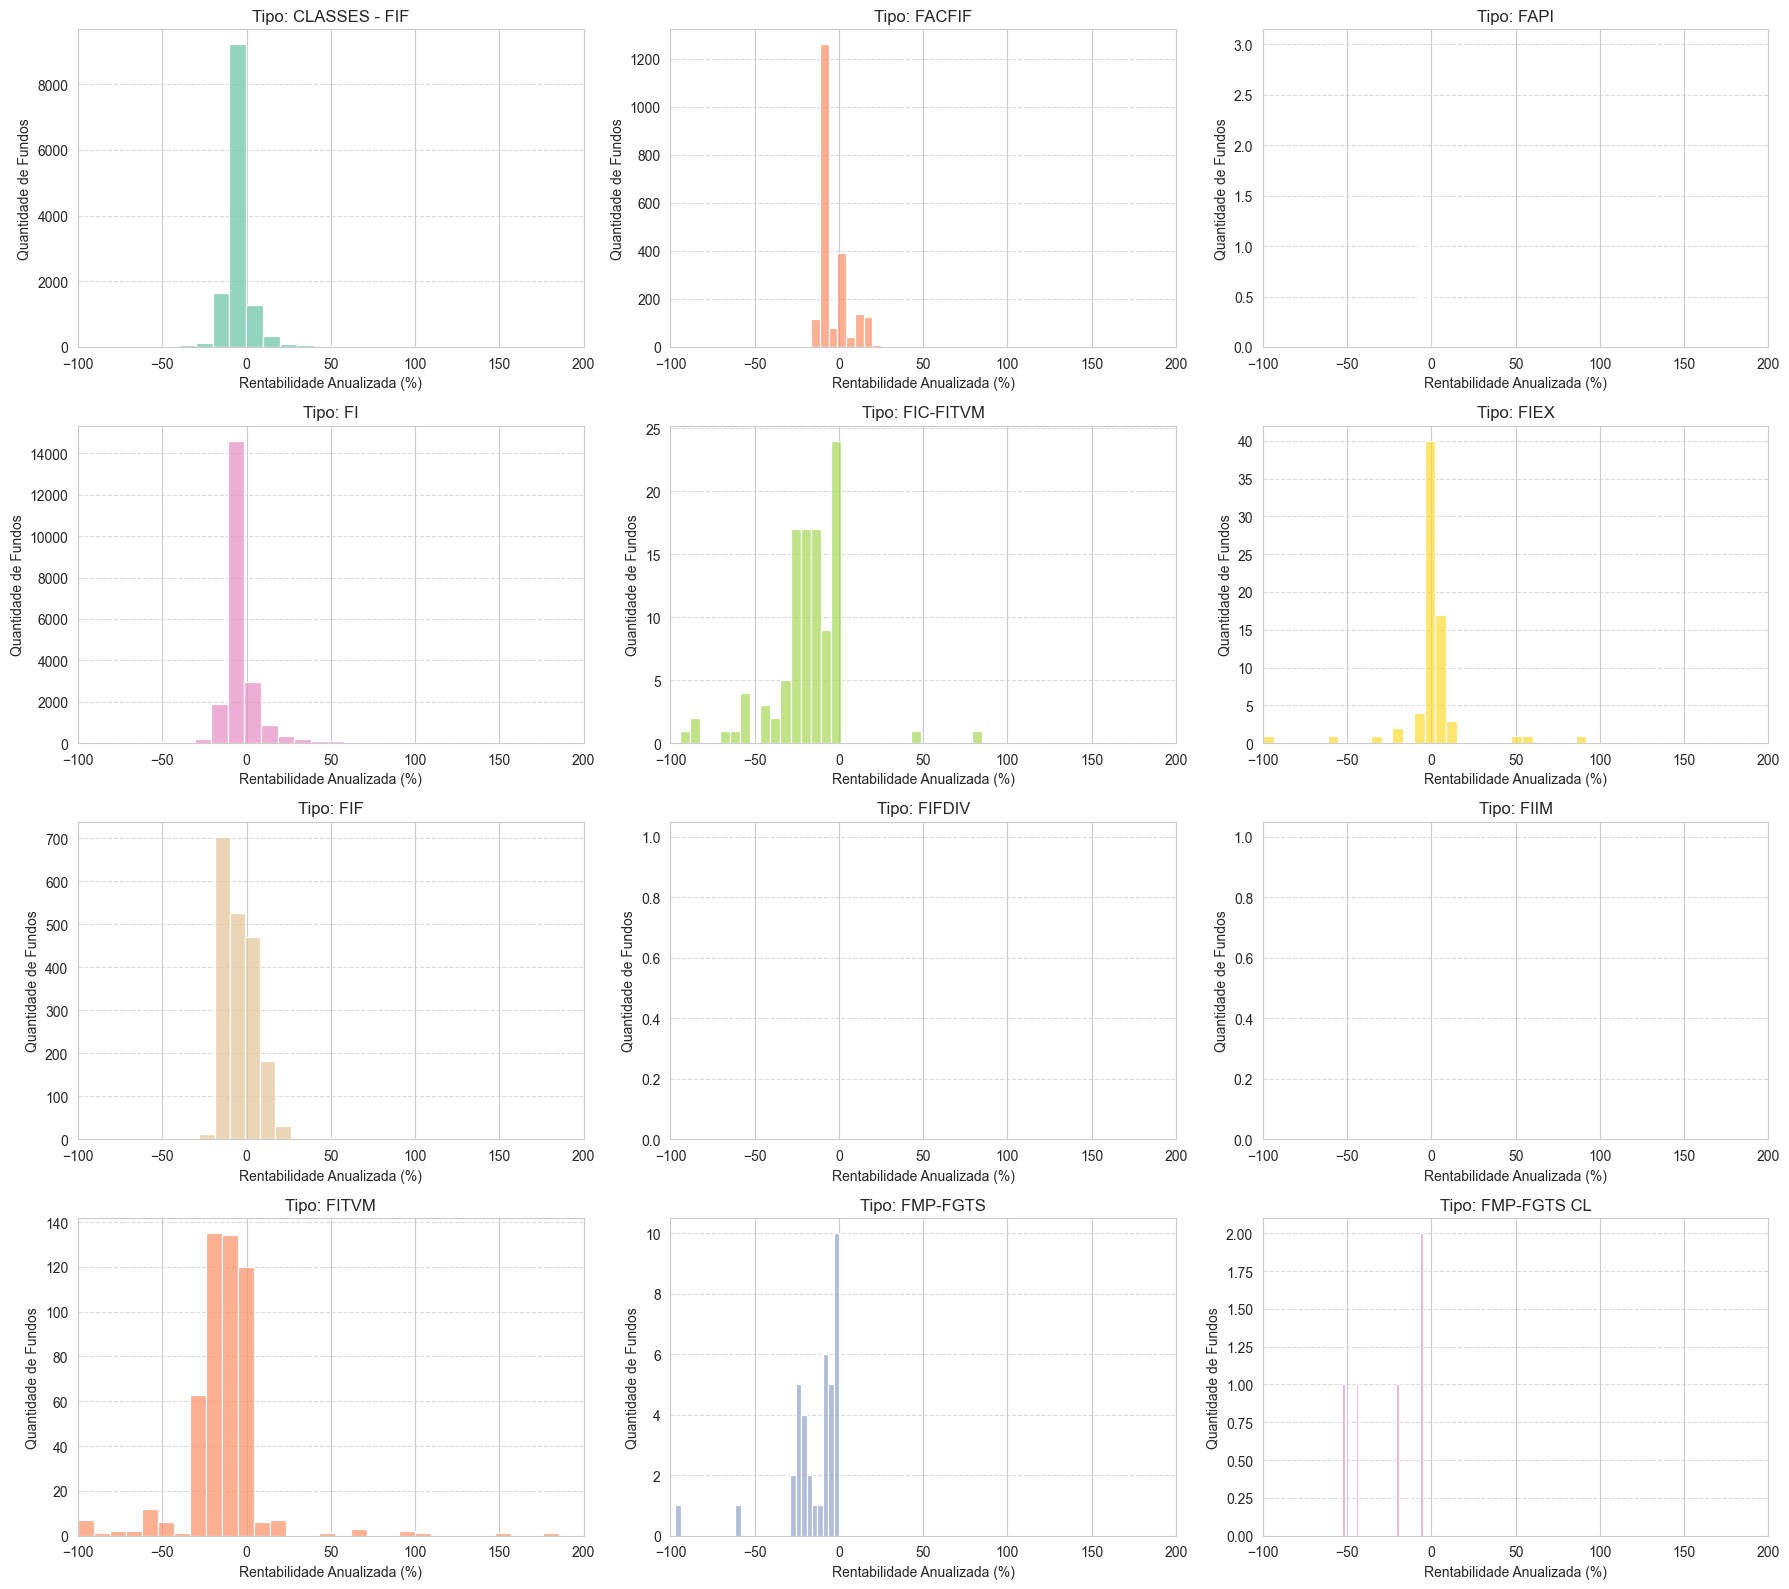

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Filtrar dados válidos e converter para pandas
valid = gold_cvm.filter(
    (F.col("rentabilidade_anualizada_pct").isNotNull()) &
    (F.col("rentabilidade_anualizada_pct") > -100) &
    (F.col("rentabilidade_anualizada_pct") < 200) &
    (F.col("TP_FUNDO").isNotNull())
)
df_plot = valid.select("rentabilidade_anualizada_pct", "TP_FUNDO").toPandas()

# Parâmetros do grid
fund_types = sorted(df_plot["TP_FUNDO"].unique())
n_types = len(fund_types)
n_cols = 3
n_rows = int(np.ceil(n_types / n_cols))

plt.figure(figsize=(6 * n_cols, 4 * n_rows))
for idx, tp in enumerate(fund_types):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.histplot(
        df_plot[df_plot["TP_FUNDO"] == tp]["rentabilidade_anualizada_pct"],
        bins=30, kde=False, color=sns.color_palette("Set2")[idx % 8], alpha=0.7
    )
    plt.title(f"Tipo: {tp}")
    plt.xlabel("Rentabilidade Anualizada (%)")
    plt.ylabel("Quantidade de Fundos")
    plt.xlim(-100, 200)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

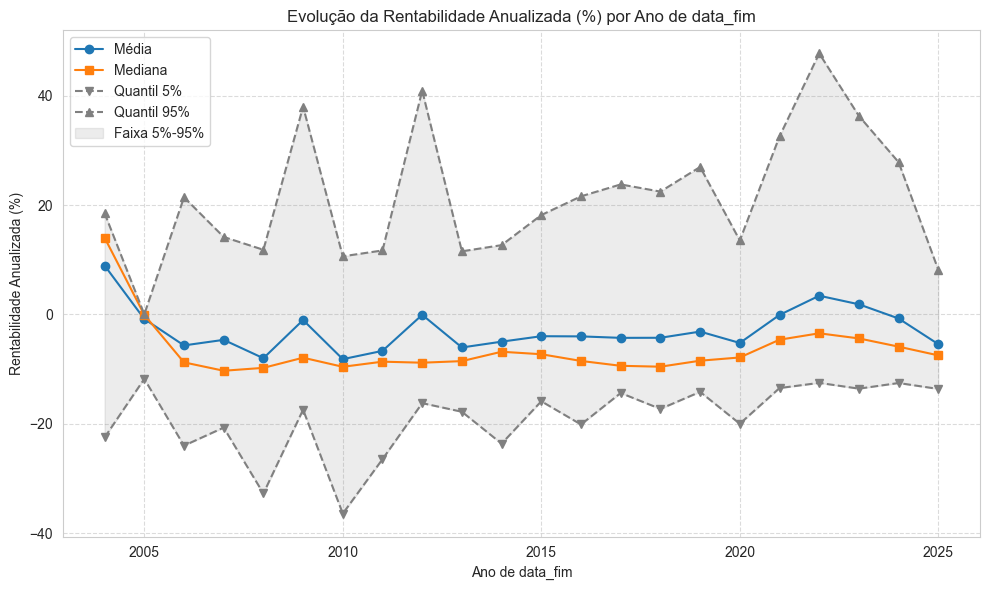

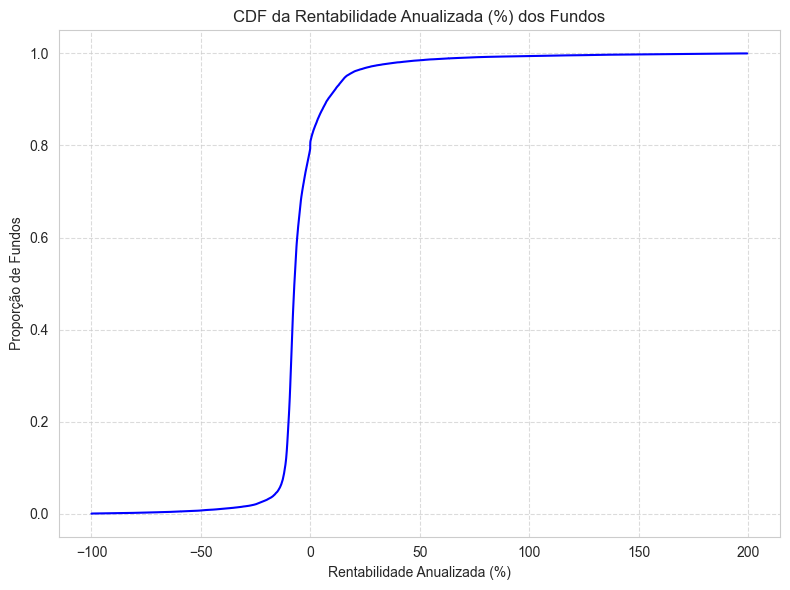

In [ ]:
# --- Preparação dos dados em pandas ---
valid = gold_cvm.filter(
    (F.col("rentabilidade_anualizada_pct").isNotNull()) &
    (F.col("rentabilidade_anualizada_pct") > -100) &
    (F.col("rentabilidade_anualizada_pct") < 200) &
    (F.col("crescimento_cotistas").isNotNull())
)
df_plot = valid.select(
    "rentabilidade_anualizada_pct", "crescimento_cotistas", "data_fim"
).toPandas()

# 2. Time Series of Median/Mean Rentabilidade (por ano de data_fim)
df_plot["ano_fim"] = pd.to_datetime(df_plot["data_fim"]).dt.year
grouped = df_plot.groupby("ano_fim")["rentabilidade_anualizada_pct"]
medias = grouped.mean()
medianas = grouped.median()
q05 = grouped.quantile(0.05)
q95 = grouped.quantile(0.95)

plt.figure(figsize=(10,6))
plt.plot(medias.index, medias.values, marker="o", label="Média")
plt.plot(medianas.index, medianas.values, marker="s", label="Mediana")
plt.plot(q05.index, q05.values, marker="v", linestyle="--", color="gray", label="Quantil 5%")
plt.plot(q95.index, q95.values, marker="^", linestyle="--", color="gray", label="Quantil 95%")
plt.fill_between(q05.index, q05.values, q95.values, color="gray", alpha=0.15, label="Faixa 5%-95%")
plt.title("Evolução da Rentabilidade Anualizada (%) por Ano de data_fim")
plt.xlabel("Ano de data_fim")
plt.ylabel("Rentabilidade Anualizada (%)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# 3. Cumulative Distribution Function (CDF)
rentabilidades = df_plot["rentabilidade_anualizada_pct"].dropna().sort_values()
cdf = np.arange(1, len(rentabilidades)+1) / len(rentabilidades)

plt.figure(figsize=(8,6))
plt.plot(rentabilidades, cdf, color="blue")
plt.title("CDF da Rentabilidade Anualizada (%) dos Fundos")
plt.xlabel("Rentabilidade Anualizada (%)")
plt.ylabel("Proporção de Fundos")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# --- Preparação dos dados em pandas ---
valid = gold_cvm.filter(
    (F.col("rentabilidade_anualizada_pct").isNotNull()) &
    (F.col("rentabilidade_anualizada_pct") > -100) &
    (F.col("rentabilidade_anualizada_pct") < 200) &
    (F.col("crescimento_cotistas").isNotNull())
)
df_plot = valid.select(
    "rentabilidade_anualizada_pct", "crescimento_cotistas", "data_fim"
).toPandas()

max_points = 2000
if len(df_plot) > max_points:
    df_sample = df_plot.sample(n=max_points, random_state=42)
    print(f"⚠️ Downsampling for plot: {len(df_plot)} → {max_points} points")
else:
    df_sample = df_plot

# 1. Beeswarm Plot: Rentabilidade vs. Crescimento de Cotistas
plt.figure(figsize=(10, 6))
sns.beeswarm(
    data=df_sample,  # Use the downsampled DataFrame
    x="rentabilidade_anualizada_pct",
    y="crescimento_cotistas",
    size=4,
    color="royalblue",
    alpha=0.7,
    jitter=True
)
plt.title("Beeswarm: Rentabilidade Anualizada (%) vs. Crescimento de Cotistas")
plt.xlabel("Rentabilidade Anualizada (%)")
plt.ylabel("Crescimento de Cotistas")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


⚠️ Downsampling for plot: 51443 → 2000 points


AttributeError: module 'seaborn' has no attribute 'beeswarm'

<Figure size 1000x600 with 0 Axes>

In [ ]:
import glob
import os
import shutil

tmp_dir = "tmp_gold_cvm_rentabilidade_anualizada"
final_file = "gold_cvm_rentabilidade_anualizada.parquet"

# Step 1: Write to temp folder as a single file
gold_cvm.filter(F.col("rentabilidade_anualizada_pct") != 0) \
    .orderBy(F.col("rentabilidade_anualizada_pct").desc()) \
    .withColumn("rentabilidade_anualizada_pct", format_number("rentabilidade_anualizada_pct", 2)) \
    .coalesce(1) \
    .write.mode("overwrite").parquet(tmp_dir)

# Step 2: Move/rename the .parquet file
parquet_file = glob.glob(os.path.join(tmp_dir, "*.parquet"))[0]
shutil.move(parquet_file, final_file)
shutil.rmtree(tmp_dir)